<a href="https://colab.research.google.com/github/raghavxi1/Fire_Detection_Model/blob/main/Fire_Detection_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original Dataset Shape: (2900, 32)

Features used for training:
['CO2_Room', 'CO_Room', 'H2_Room', 'Humidity_Room', 'PM05_Room', 'PM100_Room', 'PM10_Room', 'PM25_Room', 'PM40_Room', 'PM_Room_Typical_Size', 'PM_Total_Room', 'Temperature_Room', 'VOC_Room', 'VOC_Room_RAW', 'CO2_Room_Trend', 'CO_Room_Trend', 'H2_Room_Trend', 'PM05_Room_Trend', 'PM10_Room_Trend', 'PM25_Room_Trend', 'PM40_Room_Trend', 'PM100_Room_Trend', 'PM_Room_Typical_Size_Trend', 'VOC_Room_RAW_Trend']

Training the XGBoost model...
Training complete!

Model Accuracy: 96.55%

Classification Report:
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       339
           2       0.96      0.96      0.96        99
           3       0.94      0.92      0.93        83
           4       0.89      0.93      0.91        59

    accuracy                           0.97       580
   macro avg       0.94      0.95      0.95       580
weighted avg       0.97      0.97      0.97       5

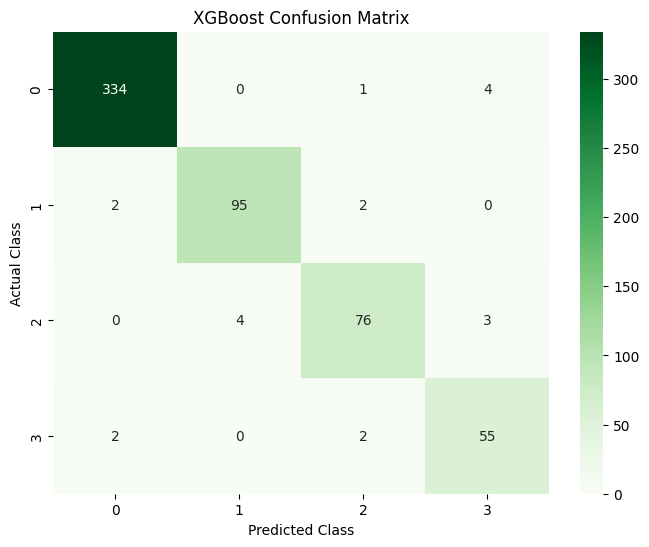

In [2]:
# --- 1. Imports ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# --- 2. Load the Dataset ---
file_path = 'Laboratory Fire Dataset containing Multi Sensor Data.csv'
df = pd.read_csv(file_path)

# --- Clean Column Names ---
# Removes hidden spaces (e.g., " class " -> "class")
df.columns = df.columns.str.strip()

print("Original Dataset Shape:", df.shape)

# --- 3. Data Cleaning & Feature Selection ---

# Columns to DROP (same as before)
cols_to_drop = [
    'Unnamed: 0',
    'Date',
    'Sensor_ID',
    'scenario_label',
    'number_label',
    'UV_Room',
    'Interval_label'
]

# Drop the columns
df_clean = df.drop(columns=cols_to_drop, errors='ignore')

# Check if 'class' exists
if 'class' not in df_clean.columns:
    raise ValueError(f"Error: 'class' column not found. Available: {df_clean.columns.tolist()}")

# Separate Input Features (X) and Target Label (y)
X = df_clean.drop(columns=['class'])
y = df_clean['class']

# --- XGBOOST SPECIFIC STEP: Fix Labels ---
# XGBoost requires classes to start at 0 (0, 1, 2, 3).
# Your data is 1, 2, 3, 4. We use LabelEncoder to fix this.
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("\nFeatures used for training:")
print(list(X.columns))

# --- 4. Split Data ---
# 80% for Training, 20% for Testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# --- 5. Train the Model (XGBoost) ---
# Initialize XGBoost Classifier
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    eval_metric='mlogloss' # Prevents warnings
)

print("\nTraining the XGBoost model...")
xgb_model.fit(X_train, y_train)
print("Training complete!")

# --- 6. Evaluation ---
y_pred = xgb_model.predict(X_test)

# Calculate accuracy
acc = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {acc * 100:.2f}%")

# Convert numeric predictions (0,1,2,3) back to original labels (1,2,3,4) for reporting
target_names = [str(cls) for cls in le.classes_]

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()